In [3]:
import pandas as pd

file_path='/Users/gimhagyeong/test/B0005_with_lowess_features.csv'
df=pd.read_csv(file_path)

# 기본 피처 (lowess 파생피처 사용 X)

In [4]:
import numpy as np
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler



# 1. 사용할 feature 선택
features1 = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load'
]
X = df[features1]

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lof = LocalOutlierFactor(
        n_neighbors=30,
        contamination=0.005   # 예상 이상치 비율
    )

y_pred = lof.fit_predict(X_scaled)
    
lof_scores = -lof.negative_outlier_factor_

    # 결과를 데이터 프레임에 추가

df['lof_pred'] = y_pred
df['lof_scores'] = lof_scores
df['lof_anomaly'] = np.where(y_pred == -1, 1, 0)  # -1을 이상치(Anomaly)로 변환

print("LOF 이상치:", df['lof_anomaly'].sum())



LOF 이상치: 252


In [5]:
contamination=0.005 # 정한 이상치 비율
threshold = np.quantile(lof_scores, 1 - contamination)
print("LOF 임계값(threshold):", threshold)

LOF 임계값(threshold): 1.676333654209548


In [6]:
anom_cycles=df[df['lof_anomaly']==1]['cycle_idx'].unique()
print('Anomalic cycles:', anom_cycles)
print('number of Anomalic cycles:', len(anom_cycles))

Anomalic cycles: [ 46 118 140 144 148 150 154 158 206 274 298 313 348 379 395 431 433 614]
number of Anomalic cycles: 18


In [7]:
cycle_anomaly_ratio = df.groupby('cycle_idx')['lof_anomaly'].mean().reset_index() # 이상 윈도우비율
# cycle_anomaly_ratio
cycle_anomaly_ratio['is_cycle_anomaly'] = (cycle_anomaly_ratio['lof_anomaly'] > 0.1).astype(int)
print("이상치윈도우가 0.1 초과인 싸이클 수:", cycle_anomaly_ratio['is_cycle_anomaly'].sum())
print("이상치윈도우가 0.1 초과인 싸이클 번호:", cycle_anomaly_ratio[cycle_anomaly_ratio['is_cycle_anomaly']==1]['cycle_idx'].values)

이상치윈도우가 0.1 초과인 싸이클 수: 2
이상치윈도우가 0.1 초과인 싸이클 번호: [ 46 158]


In [8]:
cycle_anomaly_ratio = df.groupby('cycle_idx')['lof_anomaly'].mean().reset_index() # 이상 윈도우비율
# cycle_anomaly_ratio
cycle_anomaly_ratio['is_cycle_anomaly'] = (cycle_anomaly_ratio['lof_anomaly'] > 0.05).astype(int)
print("이상치윈도우가 0.05 초과인 싸이클 수:", cycle_anomaly_ratio['is_cycle_anomaly'].sum())
print("이상치윈도우가 0.05 초과인 싸이클 번호:", cycle_anomaly_ratio[cycle_anomaly_ratio['is_cycle_anomaly']==1]['cycle_idx'].values)

이상치윈도우가 0.05 초과인 싸이클 수: 4
이상치윈도우가 0.05 초과인 싸이클 번호: [ 46 150 154 158]


In [9]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=300,
    contamination=0.005,
    random_state=42
)
y_if = iforest.fit_predict(X_scaled)   # 1 = normal, -1 = anomaly
df['if_anomaly'] = (y_if == -1).astype(int)

both = (df['lof_anomaly'] == 1) & (df['if_anomaly'] == 1)
print("LOF 이상치:", df['lof_anomaly'].sum())
print("IF 이상치 :", df['if_anomaly'].sum())
print("둘 다 이상 :", both.sum())


LOF 이상치: 252
IF 이상치 : 252
둘 다 이상 : 15


In [10]:
both_mask = (df['lof_anomaly'] == 1) & (df['if_anomaly'] == 1)
both_cycles = (
    df.loc[both_mask, 'cycle_idx']   # 공통 이상인 윈도우들의 cycle 번호
      .dropna()
      .unique()
)

both_cycles = np.sort(both_cycles)   # 정렬 (선택)
print("공통 이상 cycle 인덱스들:", both_cycles)
print("공통 이상 cycle 개수:", len(both_cycles))

공통 이상 cycle 인덱스들: [118 140 144 148 150 154 274 313 431 433]
공통 이상 cycle 개수: 10


In [11]:
import plotly.express as px

cycle_df = df.groupby('cycle_idx')['lof_scores'].mean().reset_index()

fig = px.line(
    cycle_df,
    x='cycle_idx',
    y='lof_scores',      
    title='Average LOF Score per Cycle',
    markers=True
)
fig.show()

In [12]:
cycle_anom = df.groupby('cycle_idx')['lof_anomaly'].sum().reset_index()

fig = px.bar(
    cycle_anom,
    x='cycle_idx',
    y='lof_anomaly',
    title='Number of Anomalies per Cycle'
)
fig.show()


In [13]:
cycle_peak = df.groupby('cycle_idx')['lof_scores'].max().reset_index()

fig = px.line(
    cycle_peak,
    x='cycle_idx',
    y='lof_scores',
    title='Peak LOF Score per Cycle',
    markers=True
)
fig.show()

In [14]:
# 히스토그램으로 점수 분포 겹쳐서 그리기
import plotly.express as px

fig_score = px.histogram(df, x='lof_scores', color='lof_anomaly',
                         nbins=100,
                         title='LOF Score 분포: 정상(0) vs 이상(1)',
                         labels={'lof_anomaly': 'Label (0:Normal, 1:Anomaly)'},
                         opacity=0.7,
                         log_y=True) # 데이터 개수 차이가 크므로 y축을 로그 스케일로
fig_score.show()

In [15]:
# Boxplot으로 잔차 분포 비교
fig_res = px.box(df, x='lof_anomaly', y='Voltage_measured_residual',
                 color='lof_anomaly',
                 title='정상 vs 이상: 전압 잔차(Residual) 크기 비교',
                 points='outliers') # 모든 점을 찍지 않고 이상치만 점으로 표시
fig_res.show()

In [16]:
# Cycle별 이상치 빈도 (Aging Correlation)
cycle_anomaly_counts = df[df['lof_anomaly'] == 1]['cycle_idx'].value_counts().sort_index()

fig_cycle = px.bar(
    x=cycle_anomaly_counts.index,
    y=cycle_anomaly_counts.values,
    title='<b>[Temporal Trend] Anomaly Frequency per Cycle</b>',
    labels={'x': 'Cycle Index', 'y': 'Anomaly Count'},
    color=cycle_anomaly_counts.values,
    color_continuous_scale='Viridis'
)

fig_cycle.update_layout(xaxis_title="Battery Aging (Cycle)", yaxis_title="Number of Anomalies")
fig_cycle.show()

In [17]:
import plotly.graph_objects as go

# 158번 사이클(이상치 폭발) vs 86번 사이클(정상) 비교
# 1. 비교 대상 자동 선택
# (1) 이상치 사이클: 사용자가 지정한 134번
bad_cycle_idx = 158

# (2) 정상 사이클: 데이터 개수가 가장 많은(끊김 없는) 정상 사이클 하나를 자동 선택
# 정상 데이터(Label 0) 중에서 사이클별 데이터 개수를 센다
normal_counts = df[df['lof_anomaly'] == 0]['cycle_idx'].value_counts()
# 가장 데이터가 풍부한 사이클 번호를 가져옵니다.
normal_cycle_idx = normal_counts.index[0]

print(f"=== 비교 대상 선정 ===")
print(f"이상치 사이클: {bad_cycle_idx}번")
print(f"정상 사이클 (자동선택): {normal_cycle_idx}번")

# 2. 데이터 추출
cycle_bad = df[df['cycle_idx'] == bad_cycle_idx]
cycle_normal = df[df['cycle_idx'] == normal_cycle_idx]

# 데이터 개수 확인 (혹시 0개인지 체크)
print(f" - 이상치 데이터 개수: {len(cycle_bad)}개")
print(f" - 정상 데이터 개수: {len(cycle_normal)}개")

# 3. 그래프 그리기
if len(cycle_normal) > 0 and len(cycle_bad) > 0:
    fig_compare = go.Figure()

    # 정상 사이클 (파란색 실선)
    fig_compare.add_trace(go.Scatter(
        x=np.arange(len(cycle_normal)),
        y=cycle_normal['Voltage_measured'],
        mode='lines',
        name=f'Normal Cycle ({normal_cycle_idx})',
        line=dict(color='blue', width=2),
        opacity=0.7
    ))

    # 이상치 사이클 (빨간색 점선)
    fig_compare.add_trace(go.Scatter(
        x=np.arange(len(cycle_bad)),
        y=cycle_bad['Voltage_measured'],
        mode='lines',
        name=f'Anomaly Cycle ({bad_cycle_idx})',
        line=dict(color='red', width=3, dash='dot') # 두께를 키움
    ))

    fig_compare.update_layout(
        title=f'<b>[Comparison] Normal vs Anomaly (Cycle {normal_cycle_idx} vs {bad_cycle_idx})</b>',
        xaxis_title='Time Step (Sequence)',
        yaxis_title='Voltage (V)',
        template='plotly_white',
        hovermode="x unified"
    )

    fig_compare.show()
else:
    print("오류: 선택된 사이클에 데이터가 없습니다.")

=== 비교 대상 선정 ===
이상치 사이클: 158번
정상 사이클 (자동선택): 86번
 - 이상치 데이터 개수: 353개
 - 정상 데이터 개수: 371개


In [18]:
# 누적 이상치 그래프 (Cumulative Anomaly Count)
# 시간이 지날수록 이상치가 얼마나 '쌓이는가'를 봅니다.

# 사이클별 이상치 개수 집계 (없는 사이클은 0으로 채움)
all_cycles = pd.DataFrame({'cycle_idx': df['cycle_idx'].unique()})
anomaly_counts = df[df['lof_anomaly'] == 1]['cycle_idx'].value_counts().reset_index()
anomaly_counts.columns = ['cycle_idx', 'count']

# 병합 및 정렬
trend_df = pd.merge(all_cycles, anomaly_counts, on='cycle_idx', how='left').fillna(0)
trend_df = trend_df.sort_values('cycle_idx')

# 누적 합 계산
trend_df['cumulative_count'] = trend_df['count'].cumsum()

# 시각화
fig_trend = px.area(
    trend_df,
    x='cycle_idx',
    y='cumulative_count',
    title='<b>[Cumulative Trend] Total Anomalies Over Time</b>',
    labels={'cumulative_count': 'Accumulated Anomalies', 'cycle_idx': 'Cycle Index'}
)

fig_trend.update_layout(template='plotly_white')
fig_trend.show()

In [19]:
# Feature Contribution (원인 분석)
# 로직: (이상치 그룹의 평균 - 정상 그룹의 평균) / 데이터 전체의 표준편차
# 의미: "이 피처가 정상보다 몇 시그마(Standard Deviation)만큼 벗어나 있는가?"

# 데이터 분리
normal_df = df[df['lof_anomaly'] == 0][features1]
anomaly_df = df[df['lof_anomaly'] == 1][features1]

# 차이 계산 (Z-score 관점의 차이)
diff_series = (anomaly_df.mean() - normal_df.mean()) / df[features1].std()
diff_df = diff_series.reset_index()
diff_df.columns = ['Feature', 'Deviation_Score']
diff_df = diff_df.sort_values(by='Deviation_Score', key=abs, ascending=True) # 절대값 크기순 정렬

# 시각화
fig_reason = px.bar(
    diff_df,
    x='Deviation_Score',
    y='Feature',
    orientation='h',
    title='<b>이상치 원인분석 (Feature Deviation)</b>',
    color='Deviation_Score',
    color_continuous_scale='RdBu_r', # 빨강: 높아서 문제, 파랑: 낮아서 문제
    text_auto='.2f'
)

fig_reason.add_vline(x=0, line_width=2, line_color='black')
fig_reason.update_layout(height=800)
fig_reason.show()

In [20]:
from sklearn.preprocessing import StandardScaler  
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
import pandas as pd

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load'
]

X = df[features]  
y = df['lof_anomaly'].astype(int)

scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')  # 이상치가 적으므로 class_weight로 가중치 조절
rf_model.fit(X_scaled, y)

perm_result = permutation_importance(
    rf_model,
    X_scaled,
    y,
    n_repeats=10,
    random_state=42,
    scoring='f1'  # F1은 불균형 데이터에서 더 안정적
)
				
# importance_df 결과 정리
importance_df = pd.DataFrame({  
    'feature': features,
    'importance': perm_result.importances_mean,  
    'std': perm_result.importances_std  
}).sort_values('importance', ascending=False)
				
print("\n=== Permutation Importance ===")
print(importance_df.head())

# importance_df 시각화

import plotly.express as px

fig = px.bar(
    importance_df.head(),  
    x='importance',  
    y='feature', 
    orientation='h',  
    title='Permutation Importance Result'
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'}  # 큰 값이 위로
)

fig.show()


=== Permutation Importance ===
                feature  importance       std
2  Temperature_measured    0.924774  0.014449
0      Voltage_measured    0.816497  0.023688
4          Voltage_load    0.809647  0.023453
1      Current_measured    0.337335  0.012284
3          Current_load    0.288725  0.021667


목표 A: “왜 이상이 생기는지” 설명하고 싶다 (물리 기반)

→ Deviation Score 기준으로 본다

목표 B: “모델이 어떤 근거로 분류했는지" 설명하고 싶다 (ML interpretability)

→ Permutation Importance 기준으로 본다

목표 C: “둘 다 반영해 피처 중요도를 최종 결정하고 싶다”

→ 두 개를 교차해서 공통 중요한 피처를 본다

공통 중요 피처:

Voltage_measured

Voltage_load

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import plotly.graph_objects as go


# 1. Train/Validation/Test 분할 (6:2:2)

# 고유 cycle 개수
total_cycles = df['cycle_idx'].nunique()

# 6:2:2 split 기준 cycle 개수
train_cycles = int(total_cycles * 0.6)
val_cycles = int(total_cycles * 0.8)  # train + val

# 정렬된 cycle 리스트
cycle_list = sorted(df['cycle_idx'].unique())

# 기준 cycle 번호
train_threshold_cycle = cycle_list[train_cycles - 1]
val_threshold_cycle = cycle_list[val_cycles - 1]

print(f"총 Cycle 수: {total_cycles}")
print(f"Train Cycles: 0 ~ {train_threshold_cycle} ({train_cycles}개)")
print(f"Validation Cycles: {train_threshold_cycle+1} ~ {val_threshold_cycle} ({val_cycles - train_cycles}개)")
print(f"Test Cycles: {val_threshold_cycle+1} ~ {cycle_list[-1]} ({total_cycles - val_cycles}개)")

# 1. Train / Validation / Test split
train_df = df[df['cycle_idx'] <= train_threshold_cycle].copy()
val_df = df[(df['cycle_idx'] > train_threshold_cycle) & (df['cycle_idx'] <= val_threshold_cycle)].copy()
test_df = df[df['cycle_idx'] > val_threshold_cycle].copy()

print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


# 2. Feature 준비

features1 = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load'
]

X_train = train_df[features1]
X_val = val_df[features1]
X_test = test_df[features1]


# 3. Scaler: Train만으로 학습

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n Scaler 학습 완료 (Train 기준)")


# 4. LOF: Train만으로 학습

lof = LocalOutlierFactor(
    n_neighbors=30,
    contamination='auto',
    novelty=True
)

lof.fit(X_train_scaled)

print("LOF 모델 학습 완료 (Train 기준)")


# 5. 점수 계산 (Train/Validation/Test)

train_scores = -lof.negative_outlier_factor_
val_scores = -lof.score_samples(X_val_scaled)
test_scores = -lof.score_samples(X_test_scaled)

print(f"\n LOF 점수 범위:")
print(f"   Train: {train_scores.min():.4f} ~ {train_scores.max():.4f}")
print(f"   Validation: {val_scores.min():.4f} ~ {val_scores.max():.4f}")
print(f"   Test: {test_scores.min():.4f} ~ {test_scores.max():.4f}")


# 6. Validation으로 Quantile 기반 Threshold 찾기

# 여러 quantile 시도
quantiles = [0.99, 0.995, 0.999]

print("\n" + "="*70)
print(" Quantile 기반 Threshold 비교 (Validation 기준)")
print("="*70)

quantile_results = []

for q in quantiles:
    # Threshold 계산
    thr = np.quantile(val_scores, q)
    
    # 각 데이터셋의 이상치 개수
    val_anom = (val_scores >= thr).sum()
    test_anom = (test_scores >= thr).sum()
    
    quantile_results.append({
        'quantile': q,
        'threshold': thr,
        'val_count': val_anom,
        'val_pct': val_anom / len(val_df) * 100,
        'test_count': test_anom,
        'test_pct': test_anom / len(test_df) * 100
    })
    
    print(f"\nQuantile {q:.3f} (상위 {(1-q)*100:.1f}%):")
    print(f"   Threshold: {thr:.4f}")
    print(f"   Validation 이상치개수/비율: {val_anom}개 ({val_anom/len(val_df)*100:.2f}%)")
    print(f"   Test 이상치개수/비율: {test_anom}개 ({test_anom/len(test_df)*100:.2f}%)")





총 Cycle 수: 168
Train Cycles: 0 ~ 352 (100개)
Validation Cycles: 353 ~ 483 (34개)
Test Cycles: 484 ~ 614 (34개)

Train size: 29361
Validation size: 10664
Test size: 10260

 Scaler 학습 완료 (Train 기준)
LOF 모델 학습 완료 (Train 기준)

 LOF 점수 범위:
   Train: 0.9562 ~ 6.8677
   Validation: 0.9640 ~ 3.9085
   Test: 0.9681 ~ 6.1001

 Quantile 기반 Threshold 비교 (Validation 기준)

Quantile 0.990 (상위 1.0%):
   Threshold: 2.3855
   Validation 이상치개수/비율: 107개 (1.00%)
   Test 이상치개수/비율: 1797개 (17.51%)

Quantile 0.995 (상위 0.5%):
   Threshold: 2.6356
   Validation 이상치개수/비율: 54개 (0.51%)
   Test 이상치개수/비율: 978개 (9.53%)

Quantile 0.999 (상위 0.1%):
   Threshold: 3.2174
   Validation 이상치개수/비율: 11개 (0.10%)
   Test 이상치개수/비율: 215개 (2.10%)


✔ 0.99 threshold는 너무 낮아서 test에서 과도한 이상치가 검출됨

(= 정상도 많이 이상치로 판단하는 false positive 증가)

✔ 0.995는 괜찮지만 test에서 아직 10% 가까이 잡힘

(= threshold가 여전히 낮음)

✔ 0.999는 정상 section에서는 거의 FP 없음

= test에서도 열화 구간만 적당히 잡힘
→ 가장 안정적인 threshold

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

selected_quantile = 0.999
threshold = np.quantile(val_scores, selected_quantile)


# 1. 점수 & split 정보 붙이기
train_plot = train_df.copy()
val_plot   = val_df.copy()
test_plot  = test_df.copy()

train_plot['score'] = train_scores
val_plot['score']   = val_scores
test_plot['score']  = test_scores

train_plot['split'] = 'train'. 
val_plot['split']   = 'val'
test_plot['split']  = 'test'

full = pd.concat([train_plot, val_plot, test_plot], ignore_index=True)

# 이상치 여부
# cycle_idx > 352 인 행에만 적용
full['is_anom'] = np.where(
    full['cycle_idx'] > 352, 
    full['score'] >= threshold, 
    False  # 또는 기존 값 유지하고 싶으면: full['is_anom']
)

# 2. cycle 단위 요약 (예: max score, 이상치 비율)
cycle_summary = (
    full.groupby(['split', 'cycle_idx'])
        .agg(
            max_score=('score', 'max'),
            mean_score=('score', 'mean'),
            frac_anom=('is_anom', 'mean')   # 해당 cycle 내 이상치 비율
        )
        .reset_index()
)

# cycle에 하나라도 이상치 있으면 True
cycle_summary['has_anom'] = cycle_summary['frac_anom'] > 0
cycle_summary['has_anom'] = cycle_summary['has_anom'].map({True: 'anomaly cycle', False: 'normal cycle'})

# 3. cycle-wise anomaly plot (max score 기준)
fig = px.scatter(
    cycle_summary,
    x='cycle_idx',
    y='max_score',
    color='split',            # train/val/test 구분
    symbol='has_anom',        # 이상 cycle 표시
    hover_data=['frac_anom', 'mean_score'],
    title='Cycle-wise LOF anomaly (max score per cycle)'
)

# threshold 수평선 추가
fig.add_hline(
    y=thr,
    line_dash='dash',
    line_color='red',
    annotation_text=f'threshold={threshold:.4f}',
    annotation_position='top left'
)

fig.update_layout(xaxis_title='cycle_idx', yaxis_title='max LOF score')
fig.show()


In [35]:
full_cycles = full[full['is_anom'] == True]['cycle_idx'].unique()

print("Anomalic cycles:", full_cycles)
print("Number of anomalic cycles:", len(full_cycles))


Anomalic cycles: [427 461 465 469 473 477 493 497 505 509 513 517 521 525 529 533 537 541
 545 552 556 560 564 568 572 576 580 584 588 592 596 600 604 608 612 614]
Number of anomalic cycles: 36


In [32]:
import plotly.graph_objects as go

fig_hist = go.Figure()

# Histogram - Validation
fig_hist.add_trace(go.Histogram(
    x=val_scores,
    name="Validation",
    opacity=0.6,
    marker_color='blue',
    nbinsx=50
))

# Histogram - Test
fig_hist.add_trace(go.Histogram(
    x=test_scores,
    name="Test",
    opacity=0.6,
    marker_color='orange',
    nbinsx=50
))

# Threshold 표시
fig_hist.add_vline(
    x=threshold,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Threshold={threshold:.3f}",
)

fig_hist.update_layout(
    title="Histogram: Validation vs Test LOF Scores",
    barmode='overlay',
    xaxis_title="LOF anomaly score",
    yaxis_title="Count"
)

fig_hist.show()


In [33]:
import plotly.figure_factory as ff

fig_kde = ff.create_distplot(
    [val_scores, test_scores], 
    group_labels=["Validation", "Test"],
    show_hist=False,     # 히스토그램 숨김
    show_rug=False       # rug 숨김
)

# Threshold 선 표시
fig_kde.add_vline(
    x=threshold,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Threshold={threshold:.3f}"
)

fig_kde.update_layout(
    title="KDE Density: Validation vs Test LOF Scores",
    xaxis_title="LOF anomaly score",
    yaxis_title="Density"
)

fig_kde.show()


In [25]:
full

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,cycle_idx,Voltage_measured_smooth,Voltage_measured_residual,Voltage_measured_trend,Current_measured_smooth,...,Voltage_load_smooth,Voltage_load_residual,Voltage_load_trend,lof_pred,lof_scores,lof_anomaly,if_anomaly,score,split,is_anom
0,4.191492,-0.004902,24.330034,-0.0006,0.000,2,4.191492,0.000000,-0.000743,-2.012707,...,0.000,0.0,4.2060,1,1.024591,0,1,1.002931,train,False
1,4.190749,-0.001478,24.325993,-0.0006,4.206,2,4.190749,0.000000,-0.108310,-2.012723,...,4.206,0.0,1.5310,1,1.037682,0,1,1.007765,train,False
2,3.974871,-2.012528,24.389085,-1.9982,3.062,2,3.974871,0.000000,-0.119516,-2.012746,...,3.062,0.0,-0.5880,1,1.005383,0,0,1.005709,train,False
3,3.951717,-2.013979,24.544752,-1.9982,3.030,2,3.951717,0.000000,-0.020259,-2.012799,...,3.030,0.0,-0.0255,1,1.018462,0,0,1.023338,train,False
4,3.934352,-2.011144,24.731385,-1.9982,3.011,2,3.934352,0.000000,-0.015829,-2.012904,...,3.011,0.0,-0.0195,1,1.017859,0,0,1.016981,train,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,614,3.578546,0.000716,0.003035,-0.000686,...,0.000,0.0,0.0000,1,1.405421,0,0,2.875240,test,False
50281,3.581964,-0.003067,34.814770,0.0006,0.000,614,3.581578,0.000386,0.003028,-0.000689,...,0.000,0.0,0.0000,1,1.311484,0,0,3.066022,test,False
50282,3.584484,-0.003079,34.676258,0.0006,0.000,614,3.584602,-0.000118,0.003018,-0.000717,...,0.000,0.0,0.0000,1,1.469193,0,0,3.452818,test,True
50283,3.587336,0.001219,34.565580,0.0006,0.000,614,3.587614,-0.000278,0.003007,-0.000761,...,0.000,0.0,0.0000,1,1.626031,0,0,3.791177,test,True


# permutation importance

In [34]:
from sklearn.preprocessing import StandardScaler  
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
import pandas as pd

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load'
]

X = full[features]  
y = full['is_anom'].astype(int)

scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')  # 이상치가 적으므로 class_weight로 가중치 조절
rf_model.fit(X_scaled, y)

perm_result = permutation_importance(
    rf_model,
    X_scaled,
    y,
    n_repeats=10,
    random_state=42,
    scoring='f1'  # F1은 불균형 데이터에서 더 안정적
)
				
# importance_df 결과 정리
importance_df = pd.DataFrame({  
    'feature': features,
    'importance': perm_result.importances_mean,  
    'std': perm_result.importances_std  
}).sort_values('importance', ascending=False)
				
print("\n=== Permutation Importance ===")
print(importance_df.head())

# importance_df 시각화

import plotly.express as px

fig = px.bar(
    importance_df.head(),  
    x='importance',  
    y='feature', 
    orientation='h',  
    title='Permutation Importance Result'
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'}  # 큰 값이 위로
)

fig.show()


=== Permutation Importance ===
                feature  importance       std
4          Voltage_load    0.655979  0.022295
1      Current_measured    0.615424  0.016964
0      Voltage_measured    0.565056  0.031605
2  Temperature_measured    0.543123  0.019239
3          Current_load    0.061913  0.011878


# Tree Shap

🎯 SHAP Analysis - LOF 이상치 설명

전체 데이터: 50285개
이상치: 226개 (0.45%)

✅ RandomForest Surrogate 학습 중...
✅ 학습 완료 (정확도: 1.0000)

총 이상치: 226개
SHAP 분석 샘플: 20개 선택

✅ Tree SHAP Explainer 생성 중...
✅ SHAP 값 계산 중...
✅ SHAP 값 계산 완료
   shap_values type: <class 'numpy.ndarray'>
   shap_values shape: (20, 5, 2)

✅ expected_value 확인:
   type: <class 'numpy.ndarray'>
   length: 2
   values: [0.50046515 0.49953485]
   base_value: 0.49953485277539794

✅ shap_values는 3차원 배열
   Class 1 shape: (20, 5)

📊 [1/4] Summary Plot (Bar)


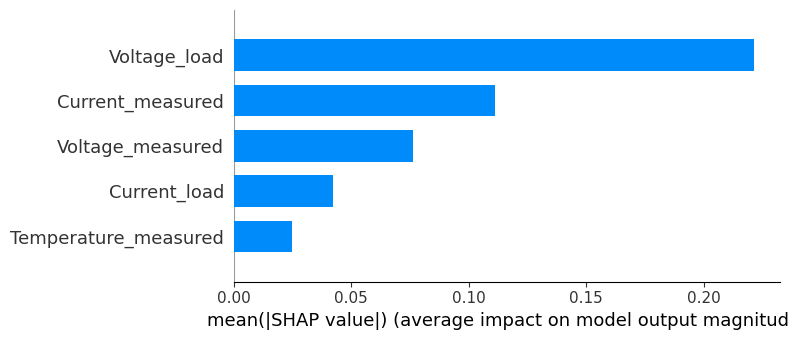


📊 [2/4] Beeswarm Plot


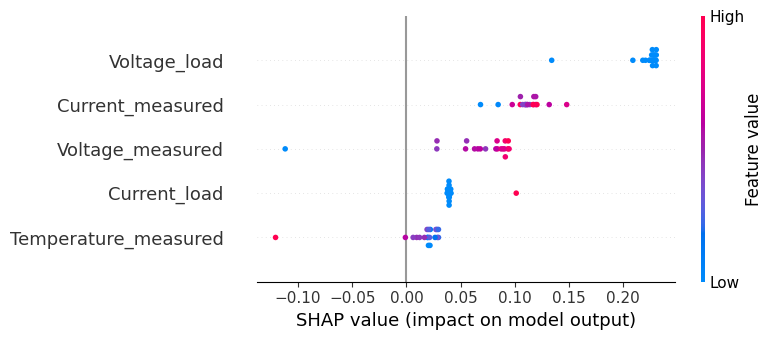


📊 [3/4] Waterfall Plot

🔍 Anomaly 1/20
   Index: 35346
   LOF Score: 3.2439


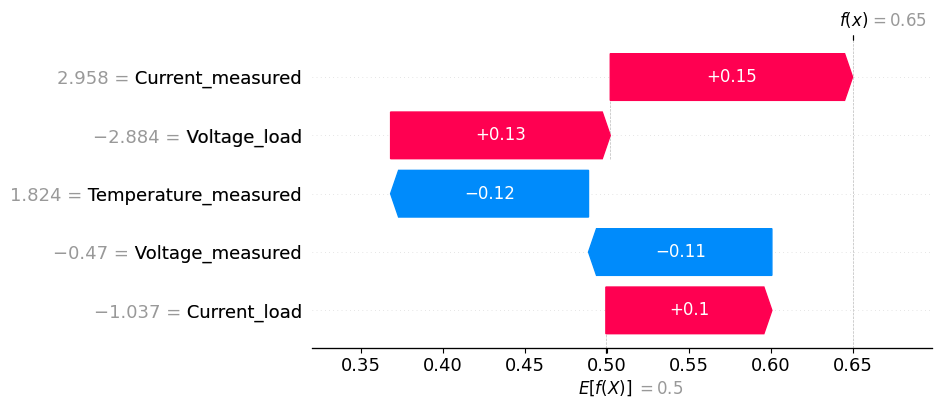


🔍 Anomaly 2/20
   Index: 38177
   LOF Score: 3.3192


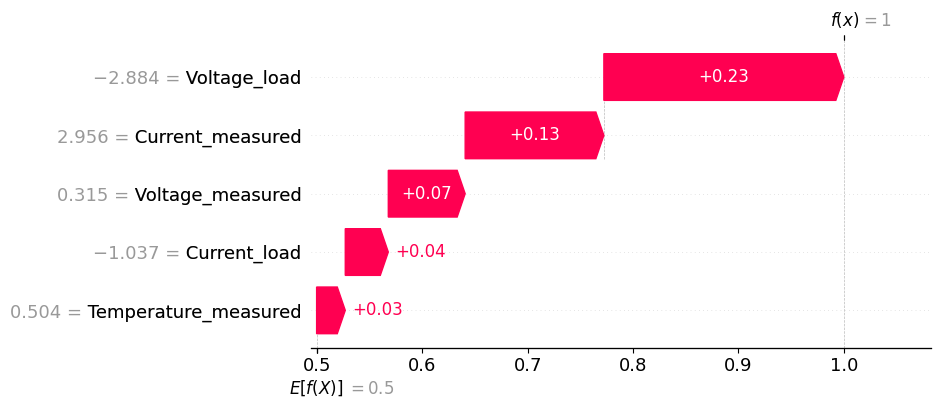


🔍 Anomaly 3/20
   Index: 38178
   LOF Score: 3.6281


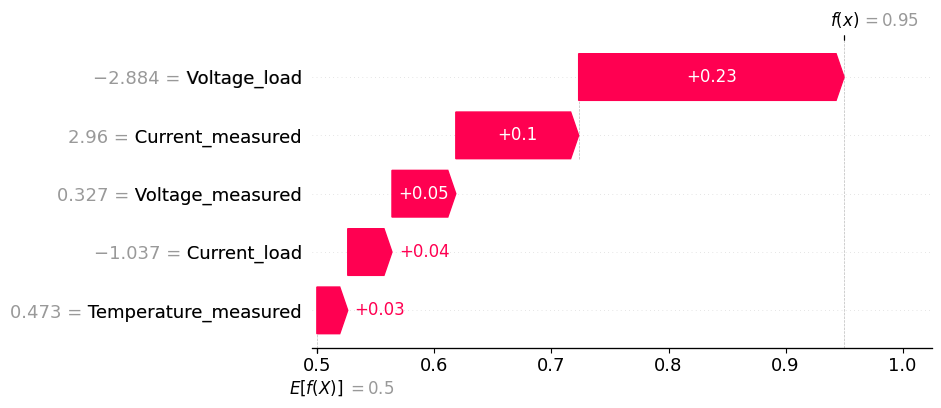


🔍 Anomaly 4/20
   Index: 38485
   LOF Score: 3.4887


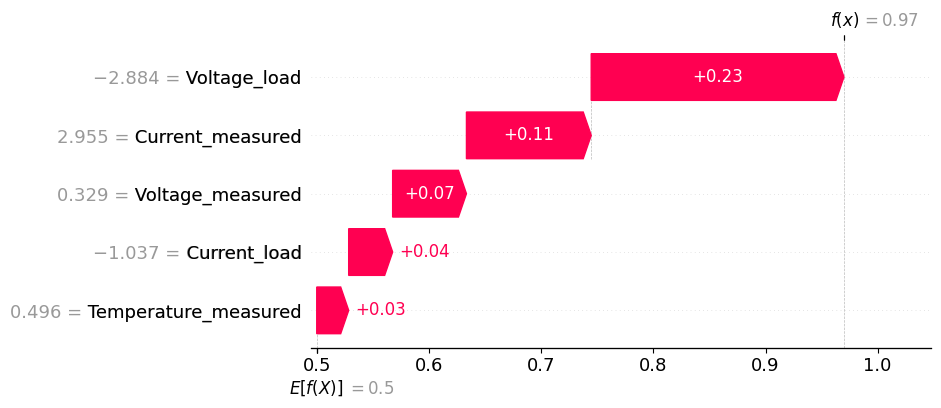


🔍 Anomaly 5/20
   Index: 38486
   LOF Score: 3.8042


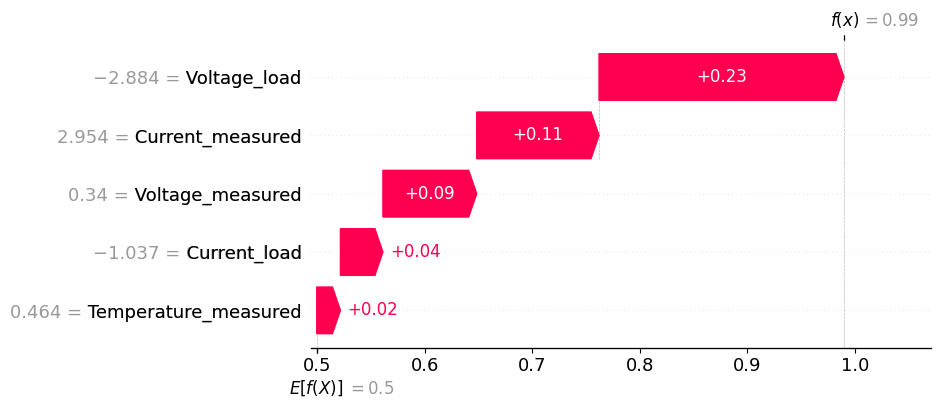


📊 [4/4] Force Plot

Force Plot 1


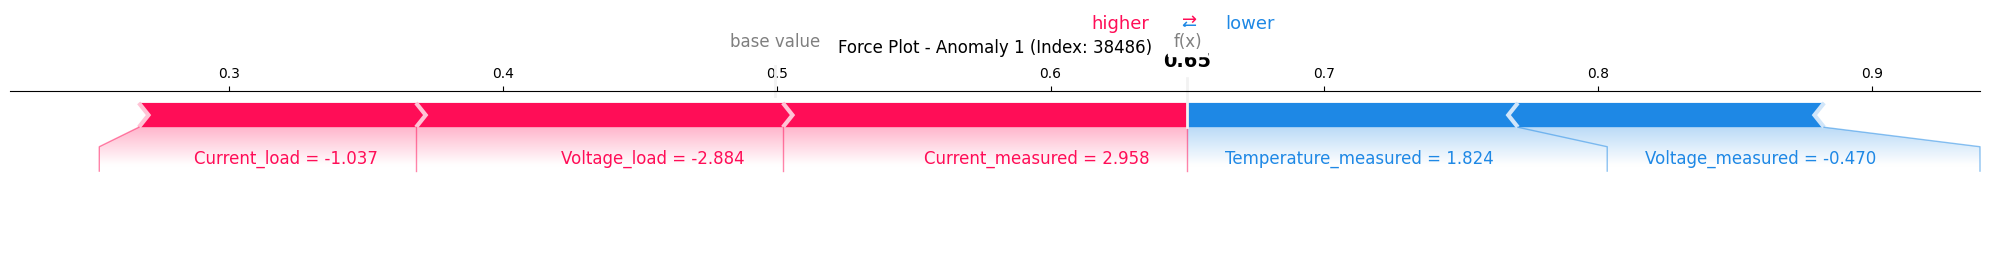


Force Plot 2


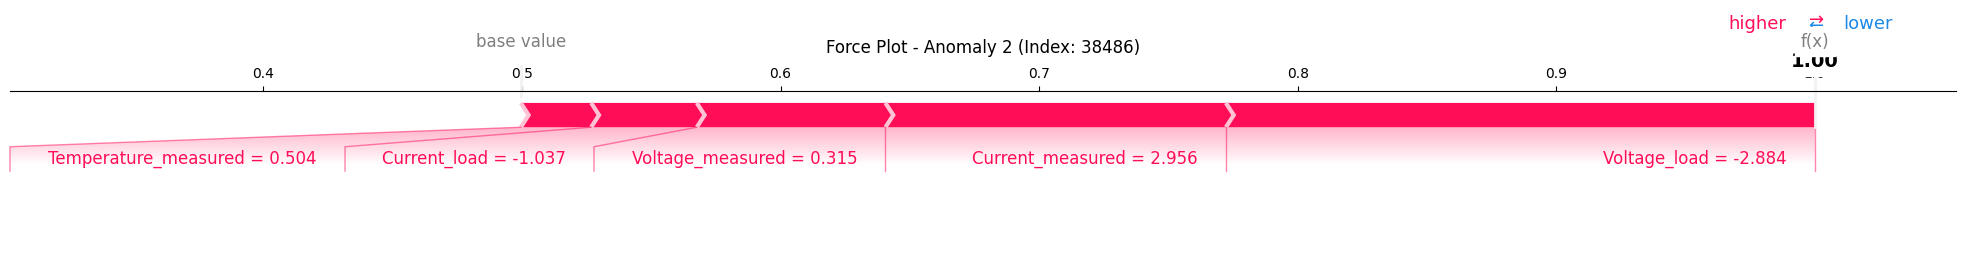


Force Plot 3


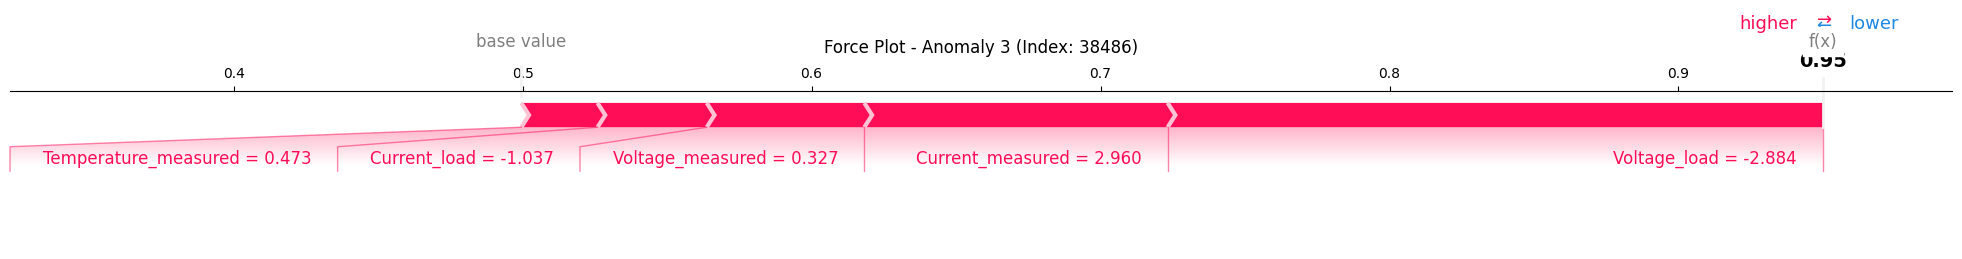


✅ SHAP Analysis 완료!

📊 Feature 중요도 요약
             Feature  Mean |SHAP|  Rank
        Voltage_load     0.221296     1
    Current_measured     0.111193     2
    Voltage_measured     0.076446     3
        Current_load     0.042398     4
Temperature_measured     0.024983     5

💡 해석:
   - Rank 1: 이상치 판단에 가장 중요
   - Waterfall Plot: 개별 anomaly의 원인
   - Beeswarm Plot: feature 값과 SHAP의 관계


In [ ]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# 1. 데이터 준비

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load'
]

X = full[features]
y = full['is_anom'].astype(int)

print(f"\n전체 데이터: {len(X)}개")
print(f"이상치: {y.sum()}개 ({y.sum()/len(y)*100:.2f}%)")

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# 2. RandomForest 학습

print("\n RandomForest Surrogate 학습 중...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_scaled_df, y)

train_score = rf_model.score(X_scaled_df, y)
print(f" 학습 완료 (정확도: {train_score:.4f})")


# 3. Anomaly 샘플 선택

anomaly_indices = full[full['is_anom'] == True].index.tolist()
print(f"\n총 이상치: {len(anomaly_indices)}개")

if len(anomaly_indices) <= 10:
    n_samples = len(anomaly_indices)
elif len(anomaly_indices) <= 30:
    n_samples = 10
else:
    n_samples = 20

print(f"SHAP 분석 샘플: {n_samples}개 선택")

sampled_indices = anomaly_indices[:n_samples]
X_anomaly = X_scaled_df.loc[sampled_indices].values


# 4. Tree SHAP

print("\n Tree SHAP Explainer 생성 중...")
explainer = shap.TreeExplainer(rf_model)

print(" SHAP 값 계산 중...")
shap_values = explainer.shap_values(X_anomaly)

print(f" SHAP 값 계산 완료")
print(f"   shap_values type: {type(shap_values)}")
print(f"   shap_values shape: {shap_values.shape if hasattr(shap_values, 'shape') else 'N/A'}")


# 5. expected_value 처리 (핵심!)

# expected_value의 형태 확인
print(f"\n expected_value 확인:")
print(f"   type: {type(explainer.expected_value)}")

if isinstance(explainer.expected_value, (list, np.ndarray)):
    print(f"   length: {len(explainer.expected_value)}")
    print(f"   values: {explainer.expected_value}")
    
    # 리스트나 배열이면 Class 1 (Anomaly) 선택
    if len(explainer.expected_value) > 1:
        base_value = float(explainer.expected_value[1])
    else:
        base_value = float(explainer.expected_value[0])
else:
    # 스칼라면 그대로 사용
    base_value = float(explainer.expected_value)

print(f"   base_value: {base_value}")


# 6. shap_values 처리

# shap_values의 차원 확인
if isinstance(shap_values, list):
    # 리스트: [Class 0, Class 1]
    shap_values_class1 = shap_values[1]
    print(f"\n shap_values는 리스트 (Class별)")
    print(f"   Class 1 shape: {shap_values_class1.shape}")
elif len(shap_values.shape) == 3:
    # 3차원: (n_samples, n_features, n_classes)
    shap_values_class1 = shap_values[:, :, 1]
    print(f"\n shap_values는 3차원 배열")
    print(f"   Class 1 shape: {shap_values_class1.shape}")
else:
    # 2차원: (n_samples, n_features) - 이진분류
    shap_values_class1 = shap_values
    print(f"\n shap_values는 2차원 배열")
    print(f"   shape: {shap_values_class1.shape}")


# 7. 시각화


# 7-1. Summary Plot (Bar)
print("\n" + "="*70)
print(" [1/4] Summary Plot (Bar)")
print("="*70)

shap.summary_plot(
    shap_values_class1,
    X_anomaly,
    plot_type="bar",
    feature_names=features
)

# 7-2. Beeswarm Plot
print("\n" + "="*70)
print(" [2/4] Beeswarm Plot")
print("="*70)

shap.summary_plot(
    shap_values_class1,
    X_anomaly,
    feature_names=features
)

# 7-3. Waterfall Plot (처음 5개)
print("\n" + "="*70)
print(" [3/4] Waterfall Plot")
print("="*70)

n_anomalies = len(X_anomaly)

for i in range(min(5, n_anomalies)):
    idx = sampled_indices[i]
    
    print(f"\n🔍 Anomaly {i+1}/{n_anomalies}")
    print(f"   Index: {idx}")
    print(f"   LOF Score: {full.loc[idx, 'score']:.4f}")

   
    #  base_values를 스칼라로 전달
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_class1[i],
            base_values=base_value,  #  스칼라 값!
            data=X_anomaly[i],
            feature_names=features
        )
    )

# 7-4. Force Plot (처음 3개)
print("\n" + "="*70)
print(" [4/4] Force Plot")
print("="*70)

for i in range(min(3, n_anomalies)):
    print(f"\nForce Plot {i+1}")

    #  소수점 3자리로 제한
     #  Feature 값 반올림 (소수점 3자리)
    data_rounded = np.round(X_anomaly[i], 3)
    
    #  Feature 이름에 값 포함 (소수점 3자리)
    feature_labels = [
        f"{feat} = {val:.3f}" 
        for feat, val in zip(features, data_rounded)
    ]
    
    # Force Plot (matplotlib 버전)
    shap.force_plot(
        base_value,
        shap_values_class1[i],
        feature_names=feature_labels,  
        matplotlib=True,
        show=False
    )
    
    # 제목 추가
    plt.title(f"Force Plot - Anomaly {i+1} (Index: {idx})", fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()


print("\n" + "="*70)
print(" SHAP Analysis 완료!")
print("="*70)


# 8. 통계 요약

print("\n" + "="*70)
print(" Feature 중요도 요약")
print("="*70)

mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)

summary_df = pd.DataFrame({
    'Feature': features,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False).reset_index(drop=True)

summary_df['Rank'] = range(1, len(features) + 1)

print(summary_df.to_string(index=False))

print("\n 해석:")
print("   - Rank 1: 이상치 판단에 가장 중요")
print("   - Waterfall Plot: 개별 anomaly의 원인")
print("   - Beeswarm Plot: feature 값과 SHAP의 관계")

# kernal shap

In [57]:
import shap

def lof_score_predict(X_array):
    """
    X_array: (n_samples, n_features) numpy array or DataFrame.values
    반환: LOF 이상도 점수 (값이 클수록 이상)
    """
    X_scaled=scaler.transform(X_array)
    return -lof.score_samples(X_scaled)

X_train_df = train_df[features1]
X_background = shap.sample(X_train_df, 100, random_state=42)


explainer = shap.KernelExplainer(
    model=lof_score_predict,  
    data=X_background          
)

def run_lof_shap_for_split(
    split_name,         # "Validation" 또는 "Test"
    df_split,           # val_df 또는 test_df
    scores_split,       # val_scores 또는 test_scores
    threshold,          # validation에서 정한 threshold (같은 값 test에 재사용)
    explainer,          # 위에서 만든 KernelExplainer
    feature_cols        # features1
):
    # 원본 건드리지 않도록 copy
    df_split = df_split.copy()
    
    # 1) 점수 & 이상치 플래그
    df_split['lof_score'] = scores_split
    df_split['is_anom'] = df_split['lof_score'] >= threshold

    X_split = df_split[feature_cols]
    X_explain = X_split[df_split['is_anom'] == True]

    n_anomalies = len(X_explain)

    print("\n" + "="*70)
    print(f" [{split_name}] SHAP 분석 시작")
    print(f"  - threshold: {threshold:.4f}")
    print(f"  - 이상 윈도우 수: {n_anomalies}")
    print("="*70)

    if n_anomalies == 0:
        print(f"⚠ [{split_name}] 구간에서 threshold 이상 이상치가 없습니다. threshold를 낮춰보는 것도 방법이에요.")
        return None, None, None

    # 2) SHAP 값 계산
    shap_values = explainer.shap_values(
        X_explain,
        nsamples="auto"   # 필요시 100, 200 등으로 지정 가능
    )

    print("shap_values.shape:", np.array(shap_values).shape)

    # 3) base_value 추출
    base_value = explainer.expected_value
    if isinstance(base_value, (list, np.ndarray)):
        base_value = np.array(base_value).mean()

    # ======================================================
    # [1/4] Summary Plot (Bar)
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [1/4] Summary Plot (Bar)")
    print("="*70)

    shap.summary_plot(
        shap_values,
        X_explain,
        plot_type="bar",
        feature_names=feature_cols
    )

    # ======================================================
    # [2/4] Beeswarm Plot
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [2/4] Beeswarm Plot")
    print("="*70)

    shap.summary_plot(
        shap_values,
        X_explain,
        feature_names=feature_cols
    )

    # ======================================================
    # [3/4] Waterfall Plot (처음 5개)
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [3/4] Waterfall Plot (처음 5개)")
    print("="*70)

    for i in range(min(5, n_anomalies)):
        print(f"\n🔍 [{split_name}] explain {i+1}/{n_anomalies}")
        original_idx = X_explain.index[i]
        print(f"   원본 인덱스: {original_idx}")
        print(f"   LOF Score: {df_split.loc[original_idx, 'lof_score']:.4f}")

        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[i],
                base_values=base_value,
                data=X_explain.iloc[i].values,
                feature_names=feature_cols
            )
        )

    # ======================================================
    # [4/4] Force Plot (처음 3개)
    # ======================================================
    print("\n" + "="*70)
    print(f" [{split_name}] [4/4] Force Plot (처음 3개)")
    print("="*70)

    for i in range(min(3, n_anomalies)):
        print(f"\nForce Plot {i+1}")
        original_idx = X_explain.index[i]

        data_row = X_explain.iloc[i].values
        data_rounded = np.round(data_row, 3)

        feature_labels = [
            f"{feat} = {val:.3f}"
            for feat, val in zip(feature_cols, data_rounded)
        ]

        shap.force_plot(
            base_value,
            shap_values[i],
            feature_names=feature_labels,
            matplotlib=True,
            show=False
        )

        plt.title(
            f"[{split_name}] Force Plot - explain {i+1} (Index: {original_idx})",
            fontsize=12,
            pad=10
        )
        plt.tight_layout()
        plt.show()

    print("\n" + "="*70)
    print(f" [{split_name}] SHAP Analysis 완료!")
    print("="*70)

    return shap_values, X_explain, base_value


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [58]:
q = 0.999
threshold = np.quantile(val_scores, q)
print("Validation 기준 threshold:", threshold)

Validation 기준 threshold: 3.2174047144322624


# kernal shap validation


 [Validation] SHAP 분석 시작
  - threshold: 3.2174
  - 이상 윈도우 수: 11


  0%|          | 0/11 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

  9%|▉         | 1/11 [00:00<00:01,  6.67it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

 18%|█▊        | 2/11 [00:00<00:01,  4.85it/s]/Library/F

shap_values.shape: (11, 5)

 [Validation] [1/4] Summary Plot (Bar)


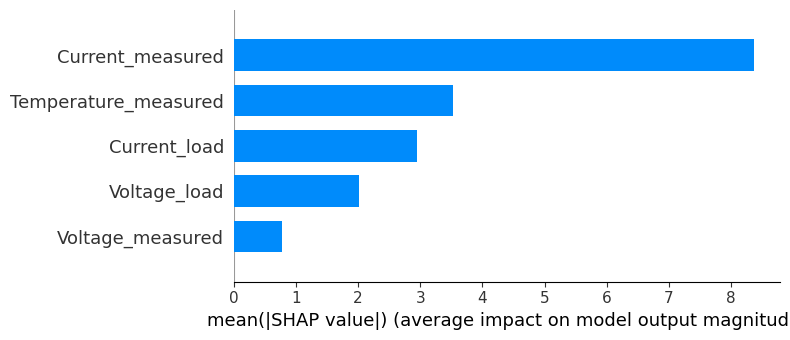


 [Validation] [2/4] Beeswarm Plot


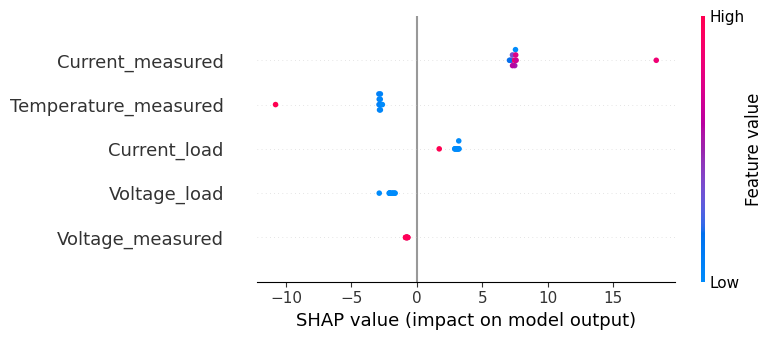


 [Validation] [3/4] Waterfall Plot (처음 5개)

🔍 [Validation] explain 1/11
   원본 인덱스: 35346
   LOF Score: 3.2439


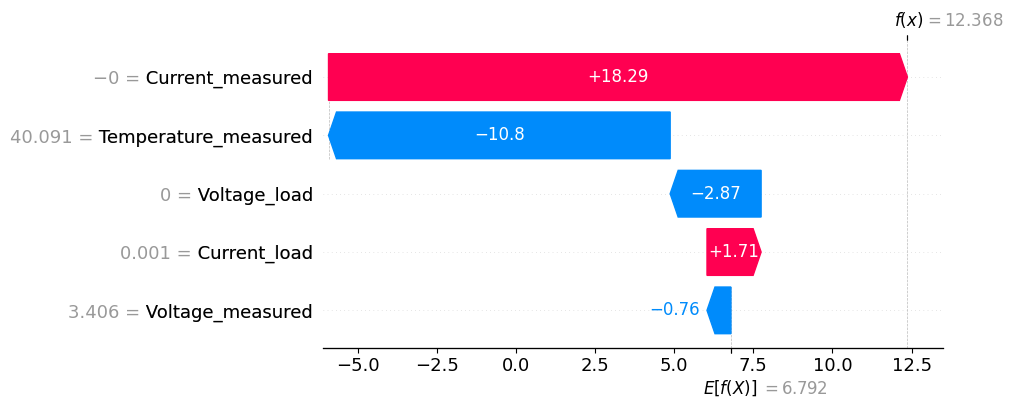


🔍 [Validation] explain 2/11
   원본 인덱스: 38177
   LOF Score: 3.3192


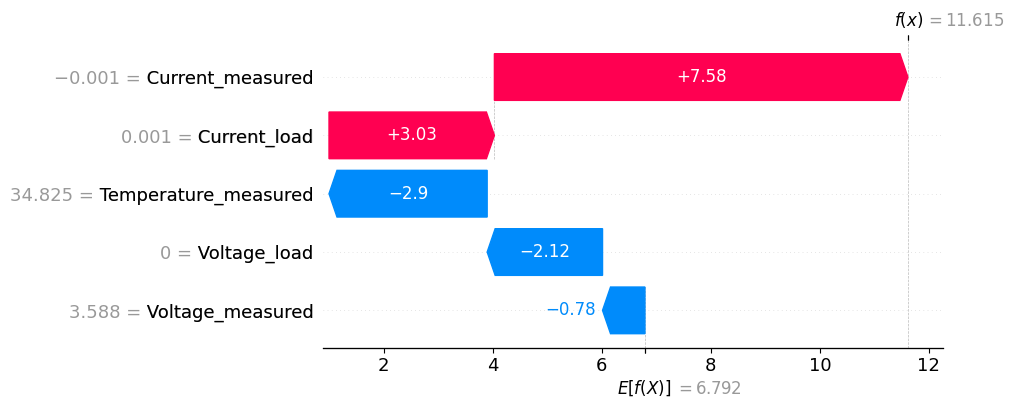


🔍 [Validation] explain 3/11
   원본 인덱스: 38178
   LOF Score: 3.6281


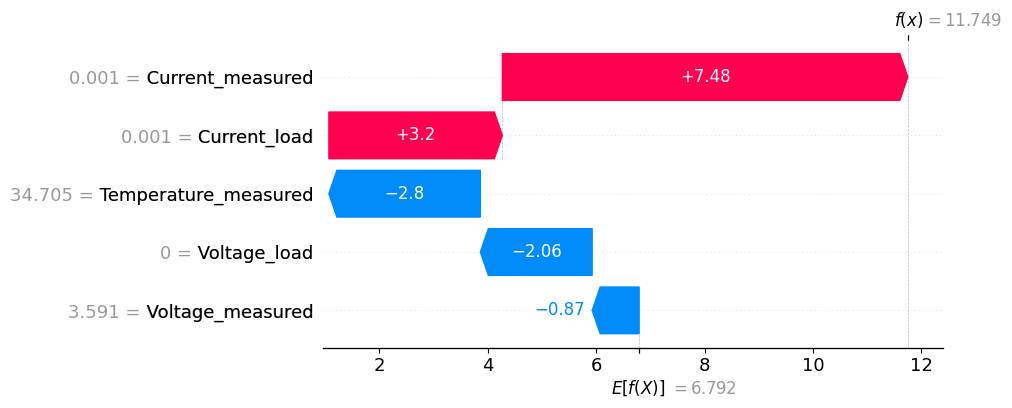


🔍 [Validation] explain 4/11
   원본 인덱스: 38485
   LOF Score: 3.4887


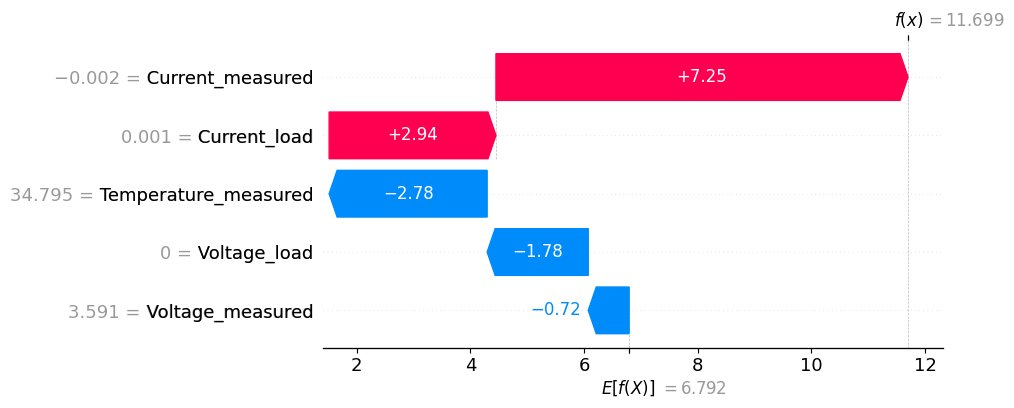


🔍 [Validation] explain 5/11
   원본 인덱스: 38486
   LOF Score: 3.8042


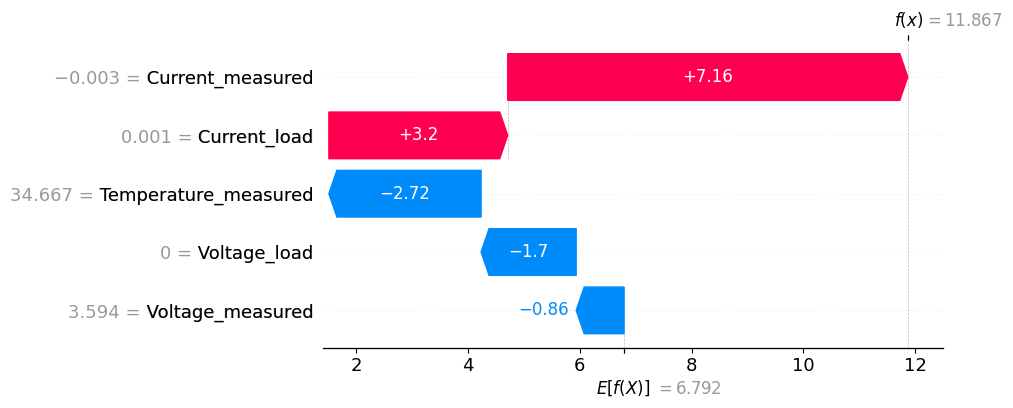


 [Validation] [4/4] Force Plot (처음 3개)

Force Plot 1


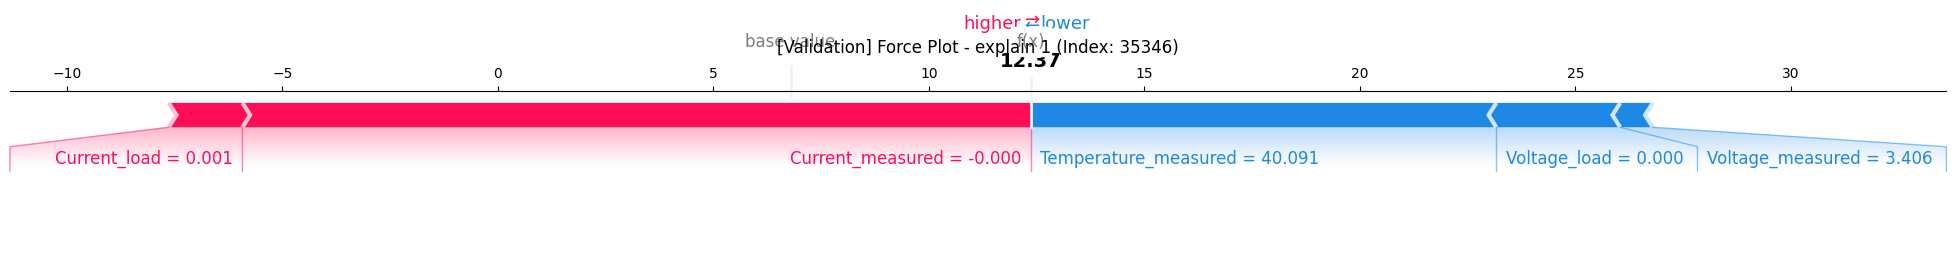


Force Plot 2


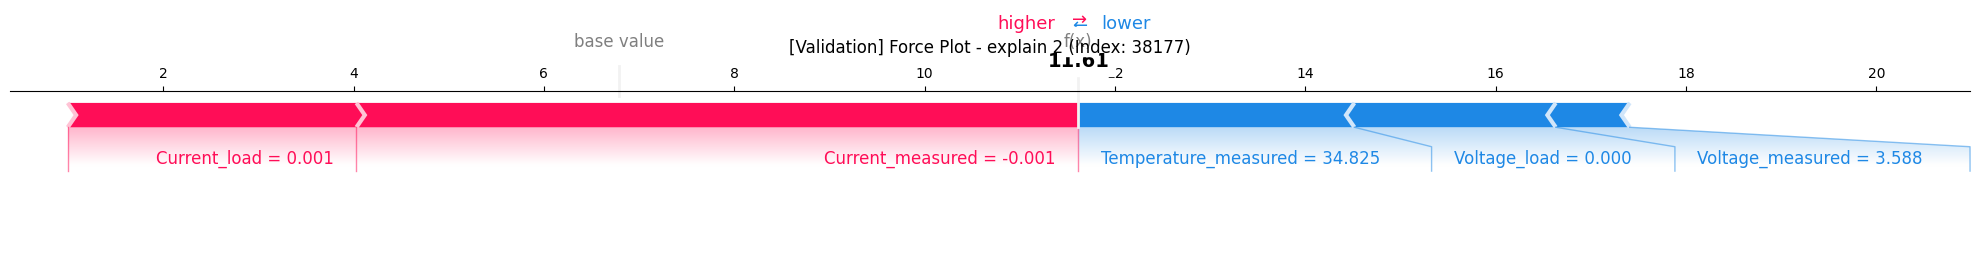


Force Plot 3


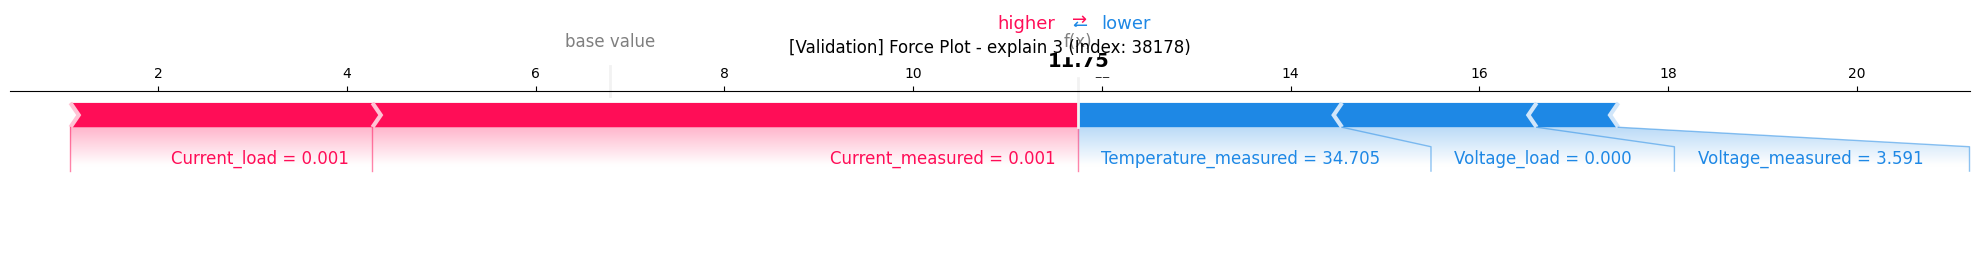


 [Validation] SHAP Analysis 완료!


In [59]:
shap_val, X_val_explain, base_val = run_lof_shap_for_split(
    split_name="Validation",
    df_split=val_df,
    scores_split=val_scores,
    threshold=threshold,
    explainer=explainer,
    feature_cols=features1
)


# kernal shap (Test)


 [Test] SHAP 분석 시작
  - threshold: 3.2174
  - 이상 윈도우 수: 215


  0%|          | 0/215 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

  0%|          | 1/215 [00:00<00:30,  7.03it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

  1%|          | 2/215 [00:00<00:43,  4.94it/s]/Librar

shap_values.shape: (215, 5)

 [Test] [1/4] Summary Plot (Bar)


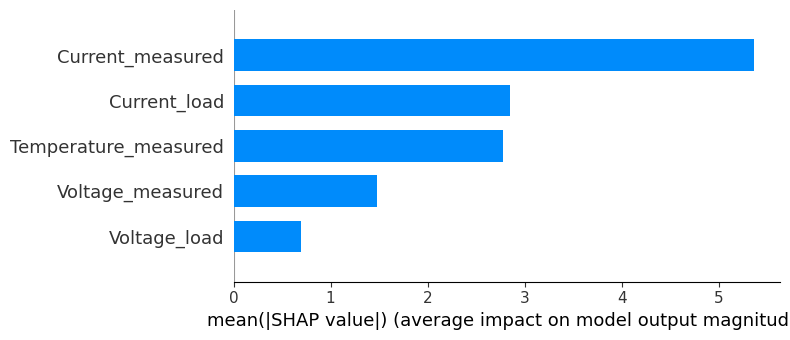


 [Test] [2/4] Beeswarm Plot


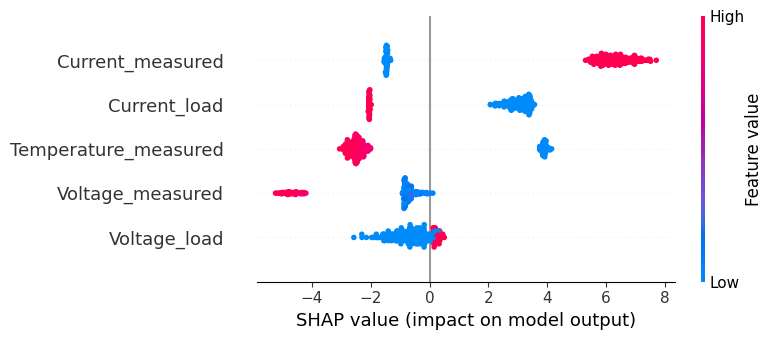


 [Test] [3/4] Waterfall Plot (처음 5개)

🔍 [Test] explain 1/215
   원본 인덱스: 40942
   LOF Score: 3.4024


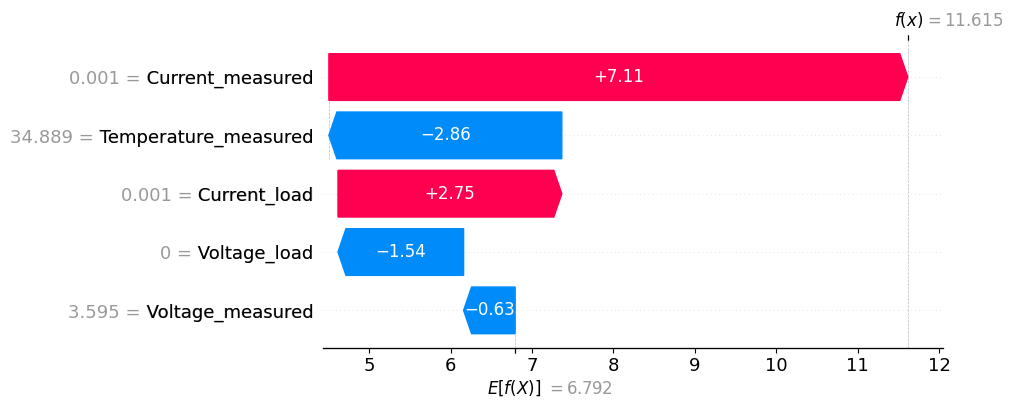


🔍 [Test] explain 2/215
   원본 인덱스: 40943
   LOF Score: 3.7374


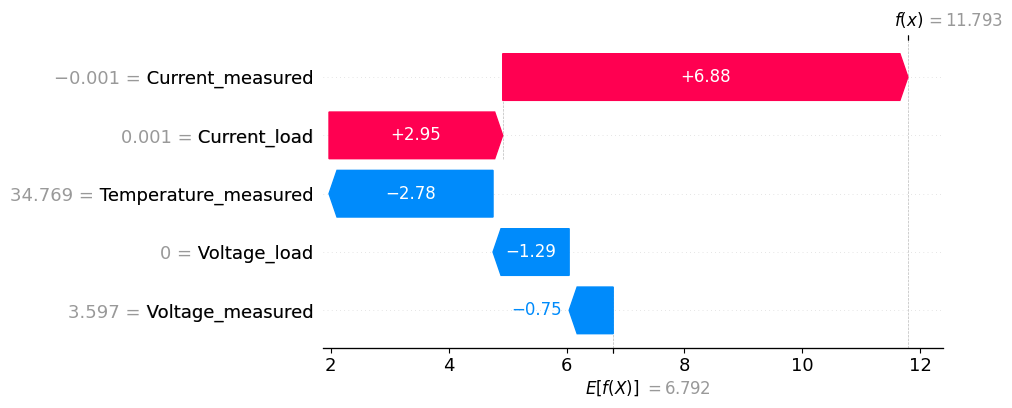


🔍 [Test] explain 3/215
   원본 인덱스: 40944
   LOF Score: 4.0774


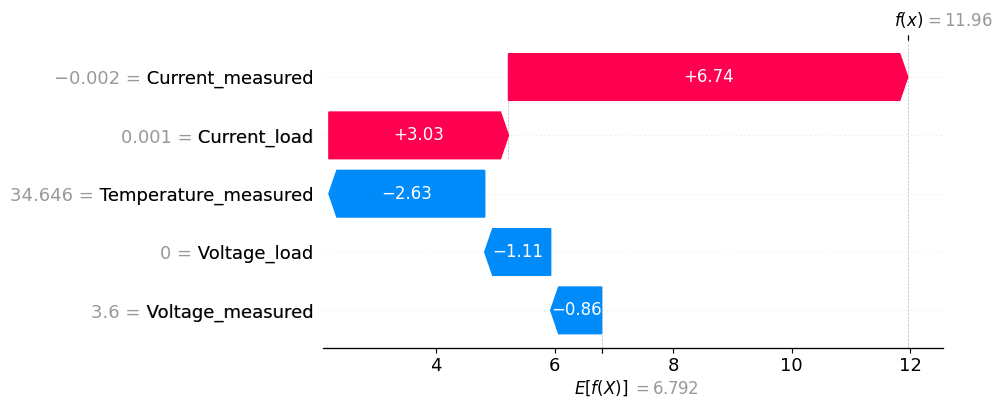


🔍 [Test] explain 4/215
   원본 인덱스: 40945
   LOF Score: 4.4000


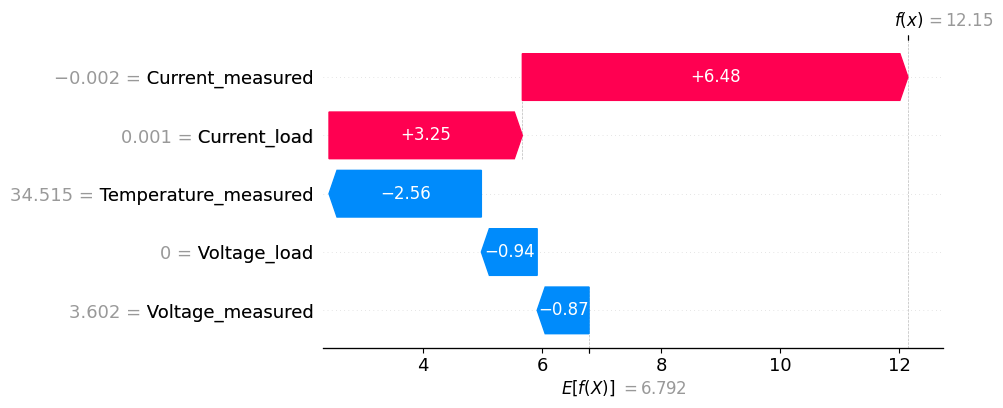


🔍 [Test] explain 5/215
   원본 인덱스: 41251
   LOF Score: 3.3660


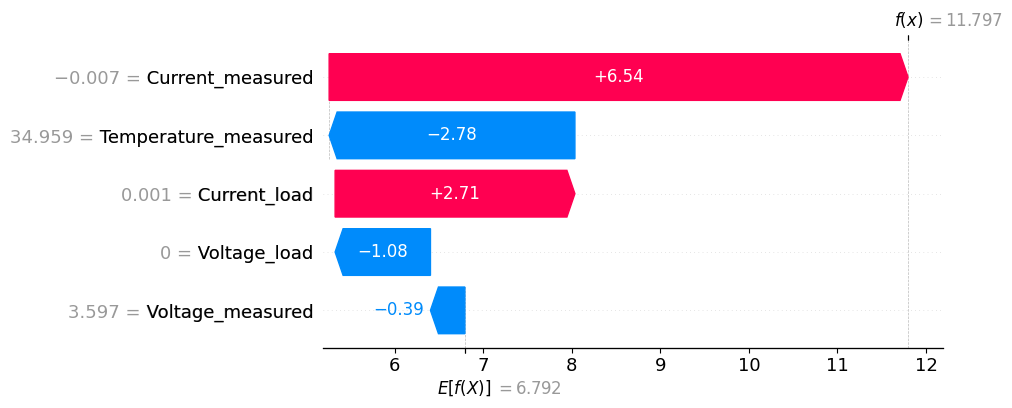


 [Test] [4/4] Force Plot (처음 3개)

Force Plot 1


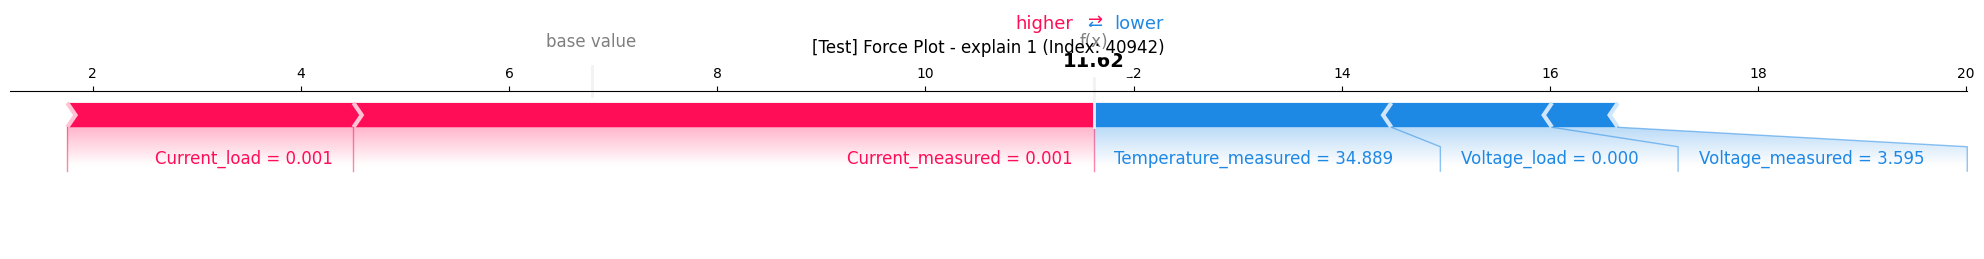


Force Plot 2


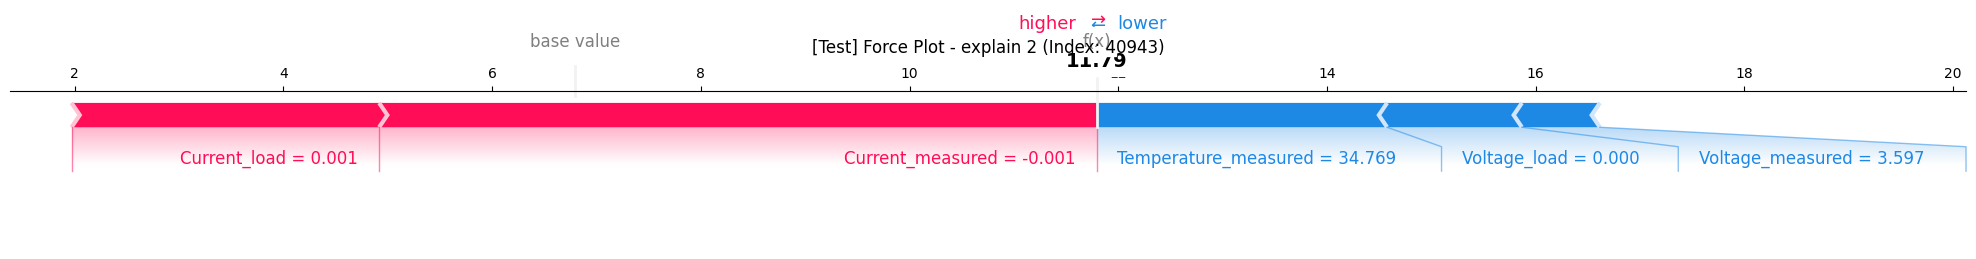


Force Plot 3


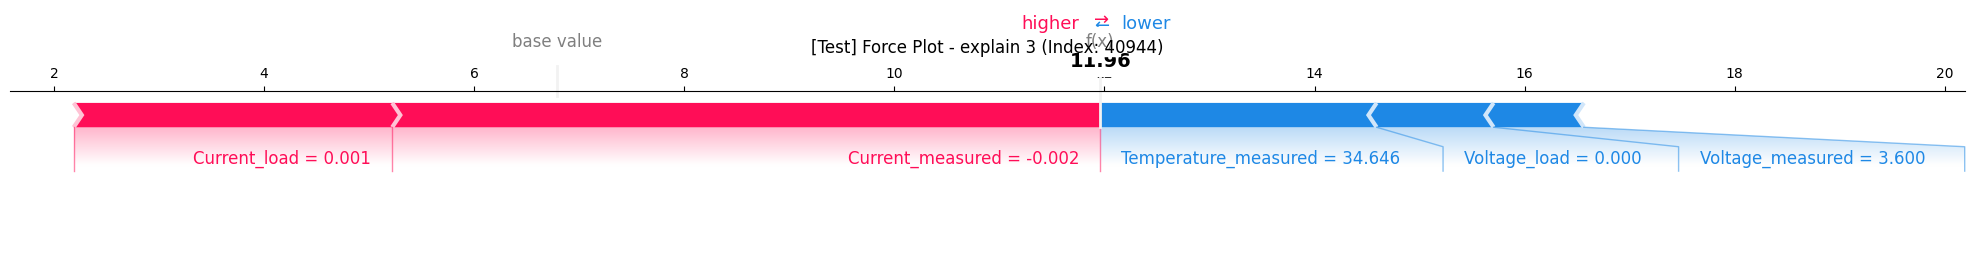


 [Test] SHAP Analysis 완료!


In [60]:
shap_test, X_test_explain, base_test = run_lof_shap_for_split(
    split_name="Test",
    df_split=test_df,
    scores_split=test_scores,
    threshold=threshold,   # 똑같은 threshold 재사용
    explainer=explainer,
    feature_cols=features1
)


In [66]:
val_df

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,cycle_idx,Voltage_measured_smooth,Voltage_measured_residual,Voltage_measured_trend,Current_measured_smooth,...,Current_load_trend,Voltage_load_smooth,Voltage_load_residual,Voltage_load_trend,lof_pred,lof_scores,lof_anomaly,if_anomaly,lof_score,is_anom
29361,4.197437,0.001119,24.263812,0.0006,0.000,356,3.974283,0.223153,-0.007780,-2.012464,...,-2.017762e-05,2.949723,-2.949723,-0.005106,1,0.988529,0,1,0.989799,False
29362,4.196787,-0.000189,24.260455,0.0006,4.212,356,3.966503,0.230283,-0.007776,-2.012332,...,-1.930164e-05,2.944617,1.267383,-0.005105,1,0.988985,0,1,0.987883,False
29363,3.990611,-2.011844,24.288318,1.9982,2.966,356,3.958731,0.031880,-0.007768,-2.012206,...,-1.740133e-05,2.939512,0.026488,-0.005104,1,1.011688,0,0,1.028700,False
29364,3.971288,-2.013848,24.350554,1.9982,2.957,356,3.950967,0.020321,-0.007758,-2.012089,...,-1.542142e-05,2.934409,0.022591,-0.005102,1,1.008020,0,0,1.026383,False
29365,3.955945,-2.010785,24.446438,1.9980,2.953,356,3.943215,0.012731,-0.007745,-2.011984,...,-1.382566e-05,2.929308,0.023692,-0.005099,1,0.971265,0,0,0.987136,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40020,3.568361,-0.003541,35.891295,0.0006,0.000,483,3.568103,0.000258,0.003262,-0.001503,...,-2.114194e-18,0.000000,0.000000,0.000000,1,0.976259,0,0,1.616213,False
40021,3.571568,-0.001001,35.760128,0.0006,0.000,483,3.571359,0.000209,0.003253,-0.001452,...,-2.818926e-18,0.000000,0.000000,0.000000,1,0.970571,0,0,1.704842,False
40022,3.574571,0.001221,35.639361,0.0006,0.000,483,3.574609,-0.000038,0.003247,-0.001395,...,4.553649e-18,0.000000,0.000000,0.000000,1,0.973776,0,0,1.798999,False
40023,3.577642,-0.003054,35.504446,0.0006,0.000,483,3.577853,-0.000211,0.003241,-0.001334,...,-4.933120e-18,0.000000,0.000000,0.000000,1,0.991866,0,0,1.986703,False


In [ ]:
test_df['lof_score']=test_scores

# Z-Deviation

In [72]:
import numpy as np

features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load'
]

def compute_feature_deviation_by_split(df_split, features,threshold,scores_split,split_name="Split"):
    """
    하나의 구간(df_split: val_df 또는 test_df) 안에서
    - 정상(lof_anomaly=0)을 baseline으로 두고
    - 이상(lof_anomaly=1)의 z-score deviation을 계산함.
    """
    df_split = df_split.copy()
    
    # 1) 점수 & 이상치 플래그
    df_split['lof_score'] = scores_split
    df_split['is_anom'] = df_split['lof_score'] >= threshold

   
    # 1) 정상 / 이상 윈도우 나누기
    normal_df = df_split[df_split['is_anom'] == False]
    anom_df   = df_split[df_split['is_anom'] == True]

    print(f"\n===== [{split_name}] deviation 분석 =====")
    print(f"정상 윈도우 수: {len(normal_df)}")
    print(f"이상 윈도우 수: {len(anom_df)}")

    if len(normal_df) == 0 or len(anom_df) == 0:
        print(f" [{split_name}] 구간에 정상 또는 이상 윈도우가 부족해서 deviation 계산 불가")
        return None

    # 2) baseline (정상 구간) 평균 / 표준편차
    baseline_mean = normal_df[features].mean()
    baseline_std  = normal_df[features].std()

    # 표준편차 0인 경우 분모가 0 되는 것을 방지
    baseline_std_replaced = baseline_std.replace(0, np.nan)

    # 3) 이상 구간의 z-score 형태 deviation
    z_deviation = ((anom_df[features] - baseline_mean) / baseline_std_replaced).abs()

    # 4) feature별 평균 deviation (큰 순으로 정렬)
    feature_deviation_mean = z_deviation.mean(axis=0).sort_values(ascending=False)

    print("\n[", split_name, "] feature deviation (상위 10개):")
    print(feature_deviation_mean.head(10))

    return feature_deviation_mean


In [73]:
q = 0.999
threshold = np.quantile(val_scores, q)
print("사용할 threshold:", threshold)


# Validation 구간 deviation
val_deviation = compute_feature_deviation_by_split(
    df_split=val_df,
    features=features,
    scores_split=val_scores,
    threshold=threshold,
    split_name="Validation"
    
)

# Test 구간 deviation
test_deviation = compute_feature_deviation_by_split(
    df_split=test_df,
    features=features,
    scores_split=test_scores,
    threshold=threshold,
    split_name="Test"
)

사용할 threshold: 3.2174047144322624

===== [Validation] deviation 분석 =====
정상 윈도우 수: 10653
이상 윈도우 수: 11

[ Validation ] feature deviation (상위 10개):
Current_load            2.570791
Current_measured        2.569977
Voltage_load            2.516121
Voltage_measured        0.420458
Temperature_measured    0.408519
dtype: float64

===== [Test] deviation 분석 =====
정상 윈도우 수: 10045
이상 윈도우 수: 215

[ Test ] feature deviation (상위 10개):
Voltage_load            2.021221
Current_load            2.019023
Current_measured        2.018960
Voltage_measured        0.651823
Temperature_measured    0.428209
dtype: float64


# feature importance (RandomForest)

In [74]:
# 1. 데이터 준비
features = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load'
]

X = full[features]
y = full['is_anom'].astype(int)

print(f"\n전체 데이터: {len(X)}개")
print(f"이상치: {y.sum()}개 ({y.sum()/len(y)*100:.2f}%)")

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. RandomForest 학습
print("\nRandomForest Surrogate 학습 중...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_scaled, y)

# 4. Feature Importance 계산
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance_df)

# 5. Plotly 시각화 (방법 1: 간단한 bar chart)
fig = px.bar(
    feature_importance_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Feature Importances (Random Forest)',
    labels={'Importance': 'Importance Score', 'Feature': 'Feature Name'},
    color='Importance',
    color_continuous_scale='Blues'
)
fig.update_layout(
    height=400,
    showlegend=False,
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()



전체 데이터: 50285개
이상치: 226개 (0.45%)

RandomForest Surrogate 학습 중...

=== Feature Importance ===
                Feature  Importance
4          Voltage_load    0.332406
0      Voltage_measured    0.276751
2  Temperature_measured    0.196769
1      Current_measured    0.131558
3          Current_load    0.062516


In [75]:
full

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,cycle_idx,Voltage_measured_smooth,Voltage_measured_residual,Voltage_measured_trend,Current_measured_smooth,...,Voltage_load_smooth,Voltage_load_residual,Voltage_load_trend,lof_pred,lof_scores,lof_anomaly,if_anomaly,score,split,is_anom
0,4.191492,-0.004902,24.330034,-0.0006,0.000,2,4.191492,0.000000,-0.000743,-2.012707,...,0.000,0.0,4.2060,1,1.024591,0,1,1.002931,train,False
1,4.190749,-0.001478,24.325993,-0.0006,4.206,2,4.190749,0.000000,-0.108310,-2.012723,...,4.206,0.0,1.5310,1,1.037682,0,1,1.007765,train,False
2,3.974871,-2.012528,24.389085,-1.9982,3.062,2,3.974871,0.000000,-0.119516,-2.012746,...,3.062,0.0,-0.5880,1,1.005383,0,0,1.005709,train,False
3,3.951717,-2.013979,24.544752,-1.9982,3.030,2,3.951717,0.000000,-0.020259,-2.012799,...,3.030,0.0,-0.0255,1,1.018462,0,0,1.023338,train,False
4,3.934352,-2.011144,24.731385,-1.9982,3.011,2,3.934352,0.000000,-0.015829,-2.012904,...,3.011,0.0,-0.0195,1,1.017859,0,0,1.016981,train,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,614,3.578546,0.000716,0.003035,-0.000686,...,0.000,0.0,0.0000,1,1.405421,0,0,2.875240,test,False
50281,3.581964,-0.003067,34.814770,0.0006,0.000,614,3.581578,0.000386,0.003028,-0.000689,...,0.000,0.0,0.0000,1,1.311484,0,0,3.066022,test,False
50282,3.584484,-0.003079,34.676258,0.0006,0.000,614,3.584602,-0.000118,0.003018,-0.000717,...,0.000,0.0,0.0000,1,1.469193,0,0,3.452818,test,True
50283,3.587336,0.001219,34.565580,0.0006,0.000,614,3.587614,-0.000278,0.003007,-0.000761,...,0.000,0.0,0.0000,1,1.626031,0,0,3.791177,test,True


In [79]:
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_scaled, full['score'])   # score 자체를 예측
y_pred_reg = rf_model.predict(X_scaled)

print("Pearson:", pearsonr(full['score'], y_pred_reg))
print("Spearman:", spearmanr(full['score'], y_pred_reg))





Pearson: PearsonRResult(statistic=np.float64(0.9983090490563085), pvalue=np.float64(0.0))
Spearman: SignificanceResult(statistic=np.float64(0.9890067531354967), pvalue=np.float64(0.0))


In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, full['score'], test_size=0.2)
rf_model.fit(X_train, y_train)
y_pred_test = rf_model.predict(X_test)
print(pearsonr(y_test, y_pred_test))
print(spearmanr(y_test, y_pred_test))


PearsonRResult(statistic=np.float64(0.9804017971357364), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9168418291138102), pvalue=np.float64(0.0))


# JSD + KDE 기반 deviation 함수

In [82]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# -----------------------------
# 1) JSD 계산용 헬퍼 함수
# -----------------------------
def js_divergence(p, q, eps=1e-12):
    """
    p, q: 같은 길이의 1D 확률분포 (합이 1인 상태를 가정)
    JSD(P, Q) = 0.5 * KL(P || M) + 0.5 * KL(Q || M), M = (P+Q)/2
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    
    # 정규화 (혹시 모를 sum != 1 방지)
    p = p / (p.sum() + eps)
    q = q / (q.sum() + eps)
    
    m = 0.5 * (p + q)
    
    jsd = 0.5 * np.sum(p * np.log((p + eps) / (m + eps))) + \
          0.5 * np.sum(q * np.log((q + eps) / (m + eps)))
    return jsd


# -----------------------------
# 2) KDE 기반 density deviation (feature 단위)
# -----------------------------
def compute_density_deviation_jsd(
    df_split,
    features,
    scores_split,
    threshold,
    split_name="Validation",
    grid_size=200
):
    """
    df_split   : 현재 split (val/test 등) 데이터프레임
    features   : 분석할 feature 리스트
    scores_split: LOF anomaly score (df_split과 길이 동일한 1D array-like)
    threshold  : LOF threshold (이상치 기준)
    split_name : 출력용 이름
    grid_size  : KDE를 평가할 grid 개수 (클수록 정밀하지만 느려짐)
    """
    
    df = df_split.copy()
    df["lof_score"] = scores_split
    df["is_anom"] = df["lof_score"] >= threshold
    
    normal_df = df.loc[~df["is_anom"], features]
    anom_df   = df.loc[df["is_anom"],  features]
    
    print(f"\n===== [{split_name}] density-based deviation (KDE + JSD) =====")
    print(f"정상 윈도우 수: {len(normal_df)}")
    print(f"이상 윈도우 수: {len(anom_df)}")
    
    # 정상/이상 데이터가 너무 적으면 반환 X
    if len(normal_df) < 10 or len(anom_df) < 5:
        print(f"[{split_name}] 정상/이상 샘플 수가 부족해 KDE 기반 deviation 계산 불가")
        return None
    
    results = []
    
    for col in features:
        x_norm = normal_df[col].dropna().values
        x_anom = anom_df[col].dropna().values
        
        # 값이 너무 단조롭거나, 유일 값이 1개 이하인 경우 스킵
        all_vals = np.concatenate([x_norm, x_anom])
        if len(np.unique(all_vals)) < 2:
            print(f" - {col}: 유니크 값이 너무 적어 스킵")
            continue
        
        # 공통 grid 설정 (정상+이상 전체 범위 기준)
        vmin, vmax = np.min(all_vals), np.max(all_vals)
        grid = np.linspace(vmin, vmax, grid_size)
        
        # 1D KDE 추정
        try:
            kde_norm = gaussian_kde(x_norm)
            kde_anom = gaussian_kde(x_anom)
        except Exception as e:
            print(f" - {col}: KDE 실패 ({e}) -> 스킵")
            continue
        
        p = kde_norm(grid)
        q = kde_anom(grid)
        
        # 음수/NaN 방지
        p = np.clip(p, 0, None)
        q = np.clip(q, 0, None)
        
        # JSD 계산 (값이 클수록 '정상 vs 이상' 밀도 차이가 큼)
        jsd = js_divergence(p, q)
        
        results.append({"feature": col, "jsd_density_deviation": jsd})
    
    if not results:
        print(f"[{split_name}] 계산된 feature가 없습니다.")
        return None
    
    dev_df = pd.DataFrame(results).sort_values(
        "jsd_density_deviation", ascending=False
    ).reset_index(drop=True)
    
    print("\n[상위 feature (density 차이 순)]")
    print(dev_df.head(10))
    
    return dev_df


In [91]:
q = 0.999
threshold = np.quantile(val_scores, q)
print("사용할 threshold:", threshold)

features = [
    "Current_load",
    "Current_measured",
    "Voltage_load",
    "Voltage_measured",
    "Temperature_measured",
]

# 예: Validation split 에서 LOF 결과가 scores_val, 데이터가 val_df 라고 가정
density_dev_val = compute_density_deviation_jsd(
    df_split=val_df,
    features=features,
    scores_split=val_scores,  # LOF score 배열
    threshold=threshold, 
    split_name="Validation",
    grid_size=200
)

# Test에서도 똑같이
density_dev_test = compute_density_deviation_jsd(
    df_split=test_df,
    features=features,
    scores_split=test_scores,
    threshold=threshold,
    split_name="Test",
    grid_size=200
)


사용할 threshold: 3.2174047144322624

===== [Validation] density-based deviation (KDE + JSD) =====
정상 윈도우 수: 10653
이상 윈도우 수: 11
 - Voltage_load: KDE 실패 (The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.) -> 스킵

[상위 feature (density 차이 순)]
                feature  jsd_density_deviation
0      Current_measured               0.668006
1          Current_load               0.666051
2      Voltage_measured               0.293148
3  Temperature_measured               0.244712

===== [Test] density-based deviation (KDE + JSD) =====
정상 윈도우 수: 10045
이상 윈도우 수: 215

[상위 feature (density 차이 순)]
                feature  jsd_density_deviation
0      Voltage_measured               0.461384
1          Curr

In [92]:
full

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,cycle_idx,Voltage_measured_smooth,Voltage_measured_residual,Voltage_measured_trend,Current_measured_smooth,...,Voltage_load_smooth,Voltage_load_residual,Voltage_load_trend,lof_pred,lof_scores,lof_anomaly,if_anomaly,score,split,is_anom
0,4.191492,-0.004902,24.330034,-0.0006,0.000,2,4.191492,0.000000,-0.000743,-2.012707,...,0.000,0.0,4.2060,1,1.024591,0,1,1.002931,train,False
1,4.190749,-0.001478,24.325993,-0.0006,4.206,2,4.190749,0.000000,-0.108310,-2.012723,...,4.206,0.0,1.5310,1,1.037682,0,1,1.007765,train,False
2,3.974871,-2.012528,24.389085,-1.9982,3.062,2,3.974871,0.000000,-0.119516,-2.012746,...,3.062,0.0,-0.5880,1,1.005383,0,0,1.005709,train,False
3,3.951717,-2.013979,24.544752,-1.9982,3.030,2,3.951717,0.000000,-0.020259,-2.012799,...,3.030,0.0,-0.0255,1,1.018462,0,0,1.023338,train,False
4,3.934352,-2.011144,24.731385,-1.9982,3.011,2,3.934352,0.000000,-0.015829,-2.012904,...,3.011,0.0,-0.0195,1,1.017859,0,0,1.016981,train,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,614,3.578546,0.000716,0.003035,-0.000686,...,0.000,0.0,0.0000,1,1.405421,0,0,2.875240,test,False
50281,3.581964,-0.003067,34.814770,0.0006,0.000,614,3.581578,0.000386,0.003028,-0.000689,...,0.000,0.0,0.0000,1,1.311484,0,0,3.066022,test,False
50282,3.584484,-0.003079,34.676258,0.0006,0.000,614,3.584602,-0.000118,0.003018,-0.000717,...,0.000,0.0,0.0000,1,1.469193,0,0,3.452818,test,True
50283,3.587336,0.001219,34.565580,0.0006,0.000,614,3.587614,-0.000278,0.003007,-0.000761,...,0.000,0.0,0.0000,1,1.626031,0,0,3.791177,test,True


In [102]:
cycle_anomaly = (
    full.groupby('cycle_idx')['score']
        .agg(mean_score='mean', 
             median_score='median', 
             max_score='max')
        .reset_index()
)


In [98]:
raw_discharge_df=pd.read_csv('/Users/gimhagyeong/test/B0005_discharge.csv')

In [103]:
cycle_anomaly

,cycle_idx,mean_score,median_score,max_score
0,2,1.090306,1.091930,1.268241
1,4,1.129965,1.102993,1.343744
2,6,1.073433,1.048345,1.403456
3,8,0.998911,0.994729,1.199197
4,10,0.992456,0.989315,1.201853
...,...,...,...,...
163,600,2.122714,2.322520,5.739968
164,604,2.106799,2.245894,6.100102
165,608,2.053424,2.156735,5.885939
166,612,1.303907,1.164079,4.045935


In [105]:
merged = cycle_anomaly.merge(raw_discharge_df[['cycle_idx','Capacity']], on='cycle_idx')


In [ ]:
merged_anomal=merged[merged['cycle_idx']>352]
print(merged_anomal[['mean_score','capacity']].corr(method='pearson'))
print(merged_anomal[['median_score','capacity']].corr(method='spearman'))
print(merged_anomal[['max_score','capacity']].corr(method='kendall'))
